## imports

In [1]:
# https://github.com/tbenst/glia
# please install using `python setup.py develop`
import glia, os, numpy as np, pandas as pd, av, matplotlib.pyplot as plt
from glob import glob
from tqdm.notebook import tqdm

## Drivers

In [2]:
data_directory = "/home/tyler/Dropbox/temp/180213/"
name = "R1_E3_AMES_240min_letters"

## Script
### read in files

## EPL program
The EyeCandy Programing Language (EPL) is a simple embedded domain-specific programming language that is embedded in JavaScript. EPL programs are used by EyeCandy to generate a sequence of objects that define a declarative rendering for a stimuli.

The embedding is shallow and nearly identical to Javascript, and is described in more detail [here](https://github.com/tbenst/eye-candy). The program used for this protocol is below. In brief, we have 10 [ETDRS letters](https://duckduckgo.com/?t=ffab&q=ETDRS+letters&iax=images&ia=images) of one of four sizes presented 100 times each for 0.5 seconds. Each letter stimuli is presented as part of a group of 0.5 seconds of full-screen black ("SOLID"), followed by 0.5 seconds of the letter, then 0.5-1 second of black. Groups are organized into cohorts of 10 groups, one for each letter. The order of groups is shuffled, as to reduce bias in acuity from long-timescale changes (e.g. if retinal response degrades over time, later stimuli may be harder to decode).

```javascript
const metadata = {name: "letters", version: "0.3.0", inverted: false}
let repetitions = 100
let sizes = [100,200,250,300]
let durations = [0.5]


function* measureIntegrity(stimuli,every=5*60) {
    // every N seconds, do a flash
    let integrityMeta
    let elapsedTime = every
    for (let s of stimuli) {
        if (elapsedTime>=every && s.metadata.block===undefined) {
            integrityMeta = {group: r.uuid(), label: "integrity"}
            yield new Wait(1, integrityMeta)
            yield new Solid(0.5, "white", integrityMeta)
            yield new Wait(2, integrityMeta)
            elapsedTime = 0
            yield s
        } else {
            yield s
        }
        elapsedTime=elapsedTime+s["lifespan"]
    }
}

let letters = ["C", "D", "H", "K", "N", "O", "R", "S", "V", "Z"]
let x
let y
let stimuli = []
let l
let before
let after
let id
let cohort

for (let i = 0; i < repetitions; i++) {
    for (let size of sizes) {
        for (let duration of durations) {
            cohort = r.uuid(i)
            for (let letter of letters) {
                id = r.uuid(i)
                // block means "do not insert a integrity check before me"
                // backgroundColor, letter, x, y, size, color
                x = windowWidth/2 - size/2
                y = windowHeight/2 + size/2
                l = new Letter(duration, "black", letter,x,y,size, 
                    "white", {group: id, cohort: cohort, block: true})
                before = new Wait(duration, {group: id})
                after = new Wait(r.randi(0.5,1), {group: id, block: true})

                // before + lit + after = lifespan
                // this pads the white flash
                stimuli.push([before, l, after])
            }
        }
    }
}

r.shuffle(stimuli)

let stimulusGenerator = measureIntegrity(flatten(stimuli))
for (let s of stimulusGenerator) {
    yield s
}
```

## Read in files

In [3]:
def glob_one_file(path):
    results = glob(path)
    if len(results) == 1:
        return results[0]
    else:
        print("found " + str(len(results)) + " files instead of one for " + path)
        return results
    
stimulus_file = glob_one_file(os.path.join(data_directory, name + ".stim"))
frames_file = glob_one_file(os.path.join(data_directory, "*.log"))
video_file = glob_one_file(os.path.join(data_directory, "*.mkv"))

# takes ~30 seconds
metadata, stimulus_list, method = glia.read_stimulus(stimulus_file)
frame_log = pd.read_csv(frames_file)
frame_log = frame_log[:-1] # last frame is not encoded

In [4]:
# read in retinal responses (may take a minute)
retinal_data_file = glob_one_file(data_directory+"*.npz")
data = np.load(retinal_data_file)
shape = np.shape(data['training_data'])

In [5]:
# for uninteresting historical reasons,
# this data was split into 60% training, 40% validation 0% test.
# Feel free to concatenate & re-split into a more standard train/test
# split
list(data.keys())

['training_data', 'training_target', 'validation_data', 'validation_target']

In [6]:
# num_sizes x num_examples x time(ms) x H x W x C
# note that channel here means a spike-sorted unit (purported neuron)
# associated with a particular electrode
# Many channels are all zero, as no unit was found at that channel
# each number is the number of spikes (Action Potentials) in that neuron per ms
# theoretically, with perfect spike sorting, this cannot occur more than once
# every 2-3 ms, but we encode as int8 in case two units are assigned to one channel
data['training_data'].shape

(4, 660, 500, 8, 8, 10)

In [7]:
# num_sizes x num_examples
data['training_target'].shape

(4, 660)

In [8]:
print(np.unique(data['training_target']))
glia.letter_classes

[ 0  1  2  3  4  5  6  7  8  9 10]


['BLANK', 'C', 'D', 'H', 'K', 'N', 'O', 'R', 'S', 'V', 'Z']

In [9]:
# let's look at three stimuli that includes a letter
stimulus_list[3:6]

[{'start_time': 8.49776,
  'stimulus': {'age': 0,
   'backgroundColor': 'black',
   'lifespan': 0.5,
   'metadata': {'group': '077b07ed-423d-42dc-a252-ac0fb2acb823'},
   'stimulusIndex': 3,
   'stimulusType': 'WAIT'}},
 {'start_time': 9.02996,
  'stimulus': {'age': 0,
   'backgroundColor': 'black',
   'color': 'white',
   'letter': 'K',
   'lifespan': 0.5,
   'metadata': {'block': True,
    'cohort': '510a24ca-eed7-4c65-b38c-6f8c7b409f2a',
    'group': '077b07ed-423d-42dc-a252-ac0fb2acb823'},
   'size': 250,
   'stimulusIndex': 4,
   'stimulusType': 'LETTER',
   'x': 515,
   'y': 525}},
 {'start_time': 9.57948,
  'stimulus': {'age': 0,
   'backgroundColor': 'black',
   'lifespan': 0.5,
   'metadata': {'block': True,
    'group': '077b07ed-423d-42dc-a252-ac0fb2acb823'},
   'stimulusIndex': 5,
   'stimulusType': 'WAIT'}}]

In [10]:
# WARNING: times (in ms) are incorrect for the frame log--we did not originally save
# the video for this recording, so I repeated the program saving the frames
# as to get pixel values. The stimulusIndex should be correct, however.
frame_log.head()

,framenum,time,stimulusIndex
0,0,10573.710,0
1,1,10607.083,0
2,2,10640.455,0
3,3,10657.141,0
4,4,10673.826,0


## Extract one frame for each letter stimuli
This is rather boring data munging--feel free to skip reading the code

In [11]:
# sometimes we drop a frame on the first render of a stimuli, so take the last frame to be conservative
# this index in frame-space
last_frame_idx_of_stimuli = np.concatenate([
    np.where(np.diff(frame_log.stimulusIndex))[0],
    [frame_log.stimulusIndex.iloc[-1]]
])

assert len(stimulus_list) == len(last_frame_idx_of_stimuli)

In [12]:
letter_stim = list(filter(
    lambda s: s['stimulus']['stimulusType']=='LETTER',
    stimulus_list))
letter_stim_idx = [s['stimulus']['stimulusIndex']
                         for s in letter_stim]

# # take last frame of stimulus as letter is static
letter_stim_frame_idx = last_frame_idx_of_stimuli[letter_stim_idx]

In [13]:
# get first frame from video so we know the size
container = av.open(video_file)
for frame in container.decode(video=0):
    first_frame = frame.to_ndarray(format='bgr24')
    break

H, W, C = first_frame.shape
dtype = first_frame.dtype

In [14]:
# extract letters & sizes from the stimulus list

letters = sorted(list(set(map(
    lambda s: s['stimulus']['letter'],
    letter_stim))))
n_letters = len(letters)

sizes = sorted(set(map(
    lambda s: s['stimulus']['size'],
    letter_stim)))
n_sizes = len(sizes)

print(f"Number of letters: {n_letters}")
print(f"Number of sizes: {n_sizes}")


Number of letters: 10
Number of sizes: 4


In [15]:
# grab only one frame of the 100 repetitions
# TODO: include BLANK and use 
# 10 letters plus 1 for BLANK (all black)
size_letter_to_frame = np.zeros([n_sizes, n_letters+1, H, W, C], dtype=dtype)

size_letter_set = set()

# map a frame index to (size, letter) tuple
# we use only the first frame index to limit
# amount of video we must loop through
idx_to_size_letter = {}

size_to_idx = {s: i for i,s in enumerate(sizes)}

for s in letter_stim_idx:
    # note that s is an index in stimulus-space
    stim = stimulus_list[s]
    size = stim["stimulus"]["size"]
    letter = stim["stimulus"]["letter"]
    key = (size, letter)
    if not key in size_letter_set:
        # add to set so lines below occur on earliest frame idx only 
        # for this (size, letter)
        size_letter_set.add(key)
        # we index by the stimulus idx
        idx = last_frame_idx_of_stimuli[s]
        idx_to_size_letter[idx] = (size_to_idx[size], glia.letter_map[letter])
        
# ensure all size x letter combinations are present
assert len(size_letter_set)==n_sizes*n_letters

In [16]:
frame_indices = sorted(list(idx_to_size_letter.keys()))
next_frame_idx = frame_indices.pop(0)

# iterate through frames, and match to each entry in frame_indices
# seeking by time would be faster, but does not map 1:1 with frame index
# should take < 1 minute
for n,frame in tqdm(enumerate(container.decode(video=0)),total=frame_indices[-1]):
    if n==(next_frame_idx):
        size, letter = idx_to_size_letter[next_frame_idx]
        size_letter_to_frame[size, letter] = frame.to_ndarray(format='bgr24')
        if len(frame_indices)!=0:
            next_frame_idx = frame_indices.pop(0)
        else:
            break

In [17]:
def get_frame_for_letter(size:float, letter:str, size_letter_to_frame=size_letter_to_frame,
                         size_to_idx=size_to_idx):
    "Given the size and the letter, return a H x W x C ndarray."
    s = size_to_idx[size]
    l = glia.letter_classes[letter]
    return size_letter_to_frame[s,l]

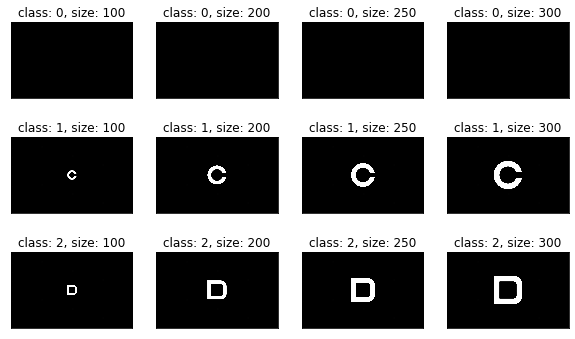

In [18]:
# visualize the size_letter_to_frame ndarray for first 3 classes

fig, axes = plt.subplots(3,4, figsize=(10,6))
for s, size in enumerate(sizes):
    for l, letter in enumerate(glia.letter_classes[:3]):
        ax = axes[l,s]
        ax.imshow(size_letter_to_frame[s,l])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"class: {l}, size: {size}")

## SVM classification

In [19]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV, train_test_split

In [20]:
# this may take a few minutes
training_100ms = glia.bin_100ms(np.expand_dims(data["training_data"],0))
validation_100ms = glia.bin_100ms(np.expand_dims(data["validation_data"],0))
for i, size in enumerate(sizes):
    print(f'==== SVC for size {size} ====')
    # note: no expand dims, hardcoded 1 ncondition
    training_target = data["training_target"][i]
    validation_target = data["validation_target"][i]
    svr = svm.SVC()
    parameters = {'C': [1, 10, 100, 1000],
                  'gamma': [0.001, 0.0001]},
    clf = GridSearchCV(svr, parameters, n_jobs=12)
    report, confusion = glia.classifier_helper(clf,
        (training_100ms[0,i], training_target),
        (validation_100ms[0,i], validation_target))
    print(report+'\n')
    print(confusion)
    
# near perfect precision & recall at size=300 declines to only ~55%
# at size=100. Note that chance is 9%

==== SVC for size 100 ====


/home/tyler/.conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


              precision    recall  f1-score   support

           0       1.00      0.97      0.99        40
           1       0.35      0.50      0.41        40
           2       0.62      0.40      0.48        40
           3       0.38      0.30      0.33        40
           4       0.65      0.80      0.72        40
           5       0.54      0.55      0.54        40
           6       0.26      0.40      0.32        40
           7       0.54      0.38      0.44        40
           8       0.52      0.38      0.43        40
           9       0.78      0.78      0.78        40
          10       0.63      0.60      0.62        40

    accuracy                           0.55       440
   macro avg       0.57      0.55      0.55       440
weighted avg       0.57      0.55      0.55       440


       BLANK   C   D   H   K   N   O   R   S   V   Z
BLANK     39   1   0   0   0   0   0   0   0   0   0
C          0  20   1   0   0   0  12   1   1   0   5
D          0   7  16   1   

/home/tyler/.conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       0.51      0.53      0.52        40
           2       0.97      0.70      0.81        40
           3       0.90      0.93      0.91        40
           4       0.80      0.82      0.81        40
           5       0.90      0.93      0.91        40
           6       0.45      0.47      0.46        40
           7       0.86      0.78      0.82        40
           8       0.71      0.88      0.79        40
           9       0.97      0.95      0.96        40
          10       0.95      0.97      0.96        40

    accuracy                           0.81       440
   macro avg       0.82      0.81      0.81       440
weighted avg       0.82      0.81      0.81       440


       BLANK   C   D   H   K   N   O   R   S   V   Z
BLANK     40   0   0   0   0   0   0   0   0   0   0
C          0  21   1   0   0   0  17   0   1   0   0
D          0   1  28   0   

/home/tyler/.conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       0.69      0.95      0.80        40
           2       1.00      0.97      0.99        40
           3       0.98      1.00      0.99        40
           4       0.98      1.00      0.99        40
           5       0.95      0.88      0.91        40
           6       0.96      0.57      0.72        40
           7       0.90      0.95      0.93        40
           8       0.93      0.97      0.95        40
           9       1.00      0.97      0.99        40
          10       0.97      0.97      0.97        40

    accuracy                           0.93       440
   macro avg       0.94      0.93      0.93       440
weighted avg       0.94      0.93      0.93       440


       BLANK   C   D   H   K   N   O   R   S   V   Z
BLANK     40   0   0   0   0   0   0   0   0   0   0
C          0  38   0   0   0   0   1   0   1   0   0
D          0   0  39   0   

/home/tyler/.conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       0.95      0.93      0.94        40
           2       1.00      1.00      1.00        40
           3       0.98      1.00      0.99        40
           4       1.00      1.00      1.00        40
           5       1.00      0.97      0.99        40
           6       0.93      0.95      0.94        40
           7       1.00      1.00      1.00        40
           8       1.00      1.00      1.00        40
           9       1.00      1.00      1.00        40
          10       1.00      1.00      1.00        40

    accuracy                           0.99       440
   macro avg       0.99      0.99      0.99       440
weighted avg       0.99      0.99      0.99       440


       BLANK   C   D   H   K   N   O   R   S   V   Z
BLANK     40   0   0   0   0   0   0   0   0   0   0
C          0  37   0   0   0   0   3   0   0   0   0
D          0   0  40   0   

## Pixel value inference

In [21]:
import torch, cv2
from torch import nn, optim, utils
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torch.nn import functional as F
import torchvision.utils
from dataclasses import dataclass

torch.manual_seed(20200525); # reproducible analysis
np.random.seed(seed=20200525)

### data munging

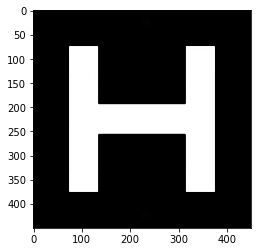

In [22]:
# choose crop parameters
biggest = max(sizes)
w1 = int((W - biggest*1.5) / 2)
w2 = W - w1
h1 = int((H - biggest*1.5) / 2)
h2 = H - h1
plt.imshow(size_letter_to_frame[-1,3,h1:h2,w1:w2])

In [23]:
training_100ms.shape

(1, 4, 660, 3200)

In [24]:
all_data = np.concatenate([training_100ms, validation_100ms], axis=2)[0]
all_targets = np.concatenate([data["training_target"], data["validation_target"]], axis=1)

# reshape to remove size dimension
n_examples = np.product(all_data.shape[:2])
X = np.zeros([n_examples, *all_data.shape[2:]])
# to avoid blowing up RAM, we store (size, letter)
# and will use dataloader to get the frame during training
Y = np.zeros([n_examples, 2], dtype=np.uint8)
for s,size in enumerate(sizes):
    for n,(x,l) in enumerate(zip(all_data[s], all_targets[s])):
        i = n * n_sizes + s
        X[i] = x # time x H x W x C
        Y[i,0] = s # size index
        Y[i,1] = l # letter index
        
# del all_data, all_targets

# 90% train, 5% validation, 5% test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=1)

X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=0.5, random_state=1)

# del X, Y

print("(N, T, H, W, C), (N, 2)")
print("train shapes: ", X_train.shape, Y_train.shape)
print("validation shapes: ", X_val.shape, Y_val.shape)
print("test shapes: ", X_test.shape, Y_test.shape)

(N, T, H, W, C), (N, 2)
train shapes:  (3960, 3200) (3960, 2)
validation shapes:  (220, 3200) (220, 2)
test shapes:  (220, 3200) (220, 2)


In [25]:
@dataclass
class LetterData(Dataset):
    X: np.ndarray
    Y: np.ndarray
    size_letter_to_frame: np.ndarray

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i):
        size_idx = self.Y[i,0]
        letter_idx = self.Y[i,1]
        frame = self.size_letter_to_frame[size_idx, letter_idx]
        return self.X[i], frame
        
def resize_4d(images, fx, fy, interpolation=cv2.INTER_LINEAR, out="ndarray",
        is_tiff=False):
    im = cv2.resize((images[0,0]), None, fx=fx, fy=fy, interpolation=interpolation)
    if out=="ndarray":
        new = np.zeros([images.shape[0],images.shape[1], *im.shape],
            dtype = np.float32)
    elif out=="memmap":
        new = np.memmap("glia_temp_memmap.mmap", np.float32, "w+",
            (images.shape[0],images.shape[1], im.shape[0],im.shape[1]))
    for b, vol in enumerate(images):
        for z, img in enumerate(vol):
            new[b,z] = cv2.resize((img), None, fx=fx, fy=fy,
                interpolation=interpolation)
    return new

# downsample to 0.5x
small_size_letter_to_frame = resize_4d(size_letter_to_frame[:,:,h1:h2, w1:w2],1/16,1/16)[...,0]
# binarize
small_size_letter_to_frame = (small_size_letter_to_frame > 128).astype(np.float32)

train_data = LetterData(X_train, Y_train, small_size_letter_to_frame)
val_data = LetterData(X_val, Y_val, small_size_letter_to_frame)
test_data = LetterData(X_test, Y_test, small_size_letter_to_frame)
print(small_size_letter_to_frame.shape)

(4, 11, 28, 28)


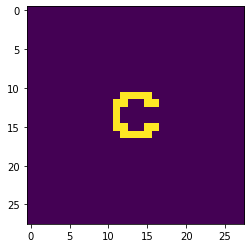

In [26]:
# look at smallest letter with downsampling
plt.imshow(small_size_letter_to_frame[0,1])
small_H, small_W = small_size_letter_to_frame[0,1].shape

###  variational autoencoder

In [27]:
# whether or not to use cuda
device = torch.device("cuda")

In [28]:
# Kingma & Welling (2014) style variational autoencoder

# subclass PyTorch Module for reverse-mode autodifferentiation 
# for easy backpropogation of loss gradient
class VAE(nn.Module):
    
    def __init__(self, n_input, n_hidden, n_latent, n_hidden2, n_output,
                 nonlinearity=F.sigmoid):
        super(VAE, self).__init__()
        self.n_input = n_input
        self.n_output = n_output
        self.n_hidden = n_hidden
        self.nonlinearity = F.sigmoid
                
        # Encoder layers
        self.hidden_encoder = nn.Linear(n_input, n_hidden)
        # mean encoding layer 
        self.mean_encoder = nn.Linear(n_hidden, n_latent)
        # log variance encoding layer 
        self.logvar_encoder = nn.Linear(n_hidden, n_latent)
        
        # Decoder layers
        self.hidden_decoder = nn.Linear(n_latent, n_hidden2)
        self.reconstruction_decoder = nn.Linear(n_hidden2, n_output)

    def encode(self, x):
        h1 = self.nonlinearity(self.hidden_encoder(x))
        return self.mean_encoder(h1), self.logvar_encoder(h1)

    def reparameterize(self, mean, logvar):
        """Reparameterize out stochastic node so the gradient can propogate 
           deterministically."""

        if self.training:
            standard_deviation = torch.exp(0.5*logvar)
            # sample from unit gaussian with same shape as standard_deviation
            epsilon = torch.randn_like(standard_deviation)
            return epsilon * standard_deviation + mean
        else:
            return mean

    def decode(self, z):
        h3 = self.nonlinearity(self.hidden_decoder(z))
        # bound output to (0,1)
        return F.sigmoid(self.reconstruction_decoder(h3))

    
    def forward(self, x):
        "A special method in PyTorch modules that is called by __call__"
        mean, logvar = self.encode(x)
        # sample an embedding, z
        z = self.reparameterize(mean, logvar)
        # return the (sampled) reconstruction, mean, and log variance
        return self.decode(z), mean, logvar



def loss_function(recon_y, y, mu, logvar, beta=1):
    "Reconstruction + KL divergence losses summed over all elements and batch."
    BCE = F.binary_cross_entropy(recon_y, y, size_average=False)

    # we want KLD = - 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    # where sigma is standard deviation and mu is mean
    # (see Appendix B of https://arxiv.org/abs/1312.6114)
    
    # see https://openreview.net/forum?id=Sy2fzU9gl for info on choosing Beta
    
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())


    return BCE + beta * KLD

In [29]:
def train(epoch, model, optimizer, train_loader, beta=1., log_interval=10):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        bz = data[0].shape[0]
        # flatten batch x height x width x channel into batch x nFeatures
        X = data[0].reshape(bz, -1).to(device)
        Y = data[1].reshape(bz, -1).to(device) # flatten
        optimizer.zero_grad()
        Y_pred, mu, logvar = model(X)
        loss = loss_function(Y_pred, Y, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    if epoch % log_interval == 0:
        print('Epoch: {} Average loss: {:.4f}'.format(
              epoch, train_loss / len(train_loader.dataset)))


def test(epoch, model, test_loader, H, W, beta=1., log_interval=10,
         save_image=True, folder="results", name="Test"):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            bz = data[0].shape[0]
            
            # flatten batch x height x width x channel into batch x nFeatures
            X = data[0].reshape(bz, -1).to(device)
            Y = data[1].reshape(bz, -1).to(device) # flatten

            Y_pred, mu, logvar = model(X)
            test_loss += loss_function(Y_pred, Y, mu, logvar).item()
            if (i == 0) and save_image:
                n = min(X.size(0), 15)
                comparison = torch.cat([Y[:n].view(-1,1,H,W),
                                   Y_pred[:n].view(-1, 1, H, W)])
                torchvision.utils.save_image(comparison.cpu(),
                         folder+f'/{name}_reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    if epoch % log_interval == 0:
        print(f'====> {name} ' + 'set loss: {:.4f}'.format(test_loss))



In [30]:
train_loader = DataLoader(LetterData(X_train.astype(np.float32),
        Y_train, small_size_letter_to_frame),
    batch_size=64, shuffle=True, pin_memory=True)
val_loader = DataLoader(LetterData(X_val.astype(np.float32),
        Y_val, small_size_letter_to_frame),
    batch_size=64, shuffle=True, pin_memory=True)
test_loader = DataLoader(LetterData(X_test.astype(np.float32),
        Y_test, small_size_letter_to_frame),
    batch_size=64, shuffle=True, pin_memory=True)

nfeatures = 28**2
# we use a latent space of dimension 2 as to get an easy-to-visualize manifold
# (see mnist/sample_*.png while running next cell)
n_input = np.prod(X_train.shape[1:])
n_hidden = 200
n_latent = 10
n_hidden2 = 200
beta = 0.9
nonlinearity = F.tanh
n_output = np.product(small_size_letter_to_frame.shape[2:])
est_params = n_input*n_hidden + n_hidden*n_latent + n_latent*n_hidden2 + n_hidden2*n_output
print(est_params)

800800


In [31]:
model = VAE(n_input, n_hidden, n_latent, n_hidden2, n_output,
            nonlinearity=nonlinearity).to(device)
optimizer = optim.Adam(model.parameters(), lr=9e-4)
!mkdir -p letters_viz && rm letters_viz/*

# this will take two minutes to run or so
# As it does, check out the letters_viz folder!
# each epoch, reconstruction examples are saved (original on top) 
# select files on right, then refresh, and double click image
# click bottom right corner of image to resize

nepochs = 100

# make grid of z1 x z2 where z1,z2 \elem (-3.5,-2.5, ..., 3.5)
nrow = 25
latents = torch.zeros(nrow,nrow,n_latent)
z1_tick = np.linspace(-3.5,3.5,nrow)
z2_tick = np.linspace(-3.5,3.5,nrow)
for i, z1 in enumerate(z1_tick):
    for j, z2 in enumerate(z2_tick):
        latents[i,j,[0,1]] = torch.tensor([z1,z2])
latents = latents.to(device)

for epoch in range(1, nepochs + 1):
    if epoch % 10 == 0:
        save_image = True
    else:
        save_image = False
    train(epoch, model, optimizer, train_loader, beta=beta)
    test(epoch, model, val_loader, small_H, small_W, beta=beta,
         save_image=save_image, folder='letters_viz', name="Validation")
    if save_image:
        with torch.no_grad():
            latent_space = model.decode(latents.view(-1,n_latent)).cpu()
            torchvision.utils.save_image(latent_space.view(-1, 1, small_H, small_W),
                       'letters_viz/sample_' + str(epoch) + '.png',nrow=nrow)

/home/tyler/.conda/lib/python3.7/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/tyler/.conda/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch: 10 Average loss: 80.0460
====> Validation set loss: 75.9959
Epoch: 20 Average loss: 54.2076
====> Validation set loss: 52.2593
Epoch: 30 Average loss: 36.7934
====> Validation set loss: 37.7081
Epoch: 40 Average loss: 28.1926
====> Validation set loss: 30.9886
Epoch: 50 Average loss: 23.3606
====> Validation set loss: 26.8491
Epoch: 60 Average loss: 20.1948
====> Validation set loss: 24.6021
Epoch: 70 Average loss: 17.9687
====> Validation set loss: 23.1866
Epoch: 80 Average loss: 16.6226
====> Validation set loss: 22.7005
Epoch: 90 Average loss: 15.3188
====> Validation set loss: 21.8530
Epoch: 100 Average loss: 14.5636
====> Validation set loss: 21.1226


In [32]:
test(epoch, model, test_loader, small_H, small_W, beta=beta,
         save_image=save_image, folder='letters_viz', name="Test")

====> Test set loss: 23.3024
